In [3]:
%matplotlib inline

import numpy as np
import nibabel as nb
import pandas as pd
import sklearn
import pylab as plt
from nilearn import plotting
from nilearn.input_data import NiftiMasker


In [14]:
!hostname

adenauer


In [4]:
def pred_real_scatter(y_test, y_test_predicted):
    plt.scatter(y_test, y_test_predicted)
    plt.plot([10,80],[10,80], 'k')
    plt.xlabel('real')
    plt.ylabel('predicted')
    ax = plt.gca()
    ax.set_aspect('equal')

# load and preprocess data MBP

In [3]:
brain_mask_file = '/Users/franzliem/Dropbox/Workspace/LeiCA/anat_templates/\
cpac_image_resources/MNI_3mm/MNI152_T1_3mm_brain_mask.nii.gz'
brain_data_file_template = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/%s_merge.nii.gz'
df_file = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/df_used.csv'
subject_list = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/subject_list.txt'
metrics_list = ['alff', 'reho', 'falff']

df = pd.read_csv(df_file, dtype='object')
df = df.set_index(df.subject_id)

s = pd.read_csv(subject_list, header=None, dtype=object)
s.columns=['subject_id']
assert np.all(s.subject_id == df.subject_id), "df not in right order"

# load and preprocess data adenauer residualized data

In [7]:
brain_mask_file = '/home/raid2/liem/Dropbox/Workspace/LeiCA/anat_templates/\
cpac_image_resources/MNI_3mm/MNI152_T1_3mm_brain_mask.nii.gz'
brain_data_file_template = '/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/\
group_metric_residuals_test_noMeanSignalRegressor/%s/LeiCA_collect_metrics/residualize_data/residualized_data.nii.gz'
df_file = '/home/raid2/liem/Dropbox/LeiCa/00_learning_test/df_used.csv'
subject_list = '/home/raid2/liem/Dropbox/LeiCa/00_learning_test/subject_list.txt'
metrics_list = ['alff', 'reho', 'falff']

df = pd.read_csv(df_file, dtype='object')
df = df.set_index(df.subject_id)

s = pd.read_csv(subject_list, header=None, dtype=object)
s.columns=['subject_id']
assert np.all(s.subject_id == df.subject_id), "df not in right order"

## extracting data with nilearn

/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test_noMeanSignalRegressor/alff/LeiCA_collect_metrics/residualize_data/residualized_data.nii.gz
/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test_noMeanSignalRegressor/reho/LeiCA_collect_metrics/residualize_data/residualized_data.nii.gz
/scr/adenauer2/Franz/LeiCA_NKI/wd_metrics/group_metric_residuals_test_noMeanSignalRegressor/falff/LeiCA_collect_metrics/residualize_data/residualized_data.nii.gz


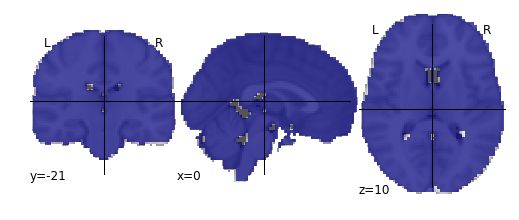

In [8]:

plotting.plot_roi(brain_mask_file)
masker = NiftiMasker(mask_img=brain_mask_file)


brain_data_list = []
for m in metrics_list:
    brain_data_file = (brain_data_file_template)%m
    print brain_data_file
    brain_data_list.append(masker.fit_transform(brain_data_file))


In [9]:
alff_2d = brain_data_list[0]
reho_2d = brain_data_list[1]
falff_2d = brain_data_list[2]

X = np.hstack([alff_2d, reho_2d, falff_2d])
X = alff_2d
print X.shape
y = df.age.values.astype(np.float)
#y = df.mean_FD_Power.values.astype(np.float)


assert X.shape[0] == y.shape[0], "shape error"

(257, 67749)


In [10]:
print X.shape
sd = X.std(axis=0)
print np.where(sd==0)

(257, 67749)
(array([], dtype=int64),)


## women only

In [11]:
y = y[(df.sex=='F').values].astype(np.float)
X = X[(df.sex=='F').values,:]

print X.shape, y.shape

(166, 67749) (166,)


## reduce X for testing

In [ ]:
#X = X[:,:100]
#X.shape

# learning

## full model without CV

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

regression_model = SVR(kernel='linear')
regression_model.fit(X,y)
y_predicted = regression_model.predict(X)

In [ ]:
mae = mean_absolute_error(y, y_predicted)
print mae

In [ ]:
plt.scatter(y, y_predicted)

## use CV

CV scores:
min: -11.596, mean: -10.795, max: -9.507


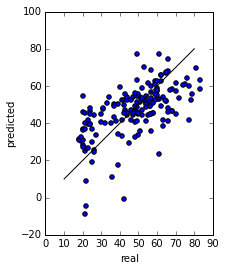

In [12]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = SVR(kernel='linear')
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=10, scoring='mean_absolute_error')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=10, n_jobs=4)
pred_real_scatter(y, y_predicted)

In [13]:
%%time

from sklearn.grid_search import GridSearchCV

regression_model = SVR(kernel='linear')

params = {
    'C': [.0001,.001,.1]
}
gs = GridSearchCV(regression_model, params, cv=20, scoring='r2', n_jobs=4)
gs.fit(X, y)
print sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

KeyboardInterrupt: 

In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)


## Ridge regression

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = linear_model.Ridge(normalize=False)
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='mean_absolute_error')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

### with GS

In [ ]:
%%time

from sklearn.grid_search import GridSearchCV

regression_model = linear_model.Ridge()
params = {
    #'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
    'normalize': [True, False]
}

gs = GridSearchCV(regression_model, params, cv=5, scoring='mean_absolute_error', n_jobs=4)
gs.fit(X, y)

In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

In [ ]:
linear_model.Ridge?


## USE GS

In [ ]:
%%time

from sklearn.grid_search import GridSearchCV

regression_model = SVR(kernel='linear')

params = {
    'C': [.1,1,10,100]
}
gs = GridSearchCV(regression_model, params, cv=5, scoring='mean_absolute_error', n_jobs=4)
gs.fit(X, y)


In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

##GradientBoostingRegressor

CV scores:
min: -12.253, mean: -10.842, max: -9.342
CPU times: user 2.63 s, sys: 1.81 s, total: 4.44 s
Wall time: 28min 27s


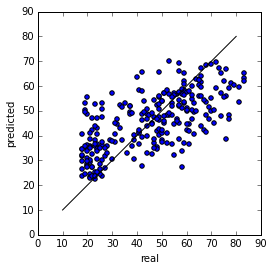

In [40]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = GradientBoostingRegressor()
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='mean_absolute_error')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

## LASSO

CV scores:
min: 0.337, mean: 0.348, max: 0.359


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


CPU times: user 223 ms, sys: 418 ms, total: 640 ms
Wall time: 1min 48s


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


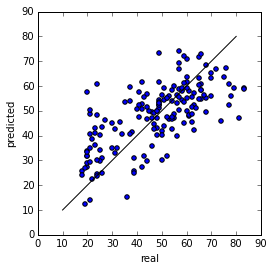

In [24]:
%%time
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = Lasso()
cv_scores = cross_val_score(regression_model, X, y, cv=2, n_jobs=4, scoring='r2')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

In [23]:
regression_model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# RFEVC

In [ ]:
%%time
from sklearn.feature_selection import RFECV

regression_model = SVR(kernel='linear')
rfecv = RFECV(estimator=regression_model, step=25000, cv=5, scoring='r2')

rfecv.fit(X, y)


In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [ ]:
rfecv.support_

## use split

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regression_model = SVR(kernel='linear')
regression_model.fit(X_train,y_train)
y_test_predicted = regression_model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)

print mae
print r2
pred_real_scatter(y_test, y_test_predicted)

In [ ]:
regression_model.coef_.shape


## output coeff nii

In [ ]:
n_imgs = regression_model.coef_.shape[1] / brain_data_list[0].shape[1]
out_list = np.hsplit(regression_model.coef_, n_imgs)
for i, out_data in enumerate(out_list):
    coef_img = masker.inverse_transform(out_data)
    coef_img.to_filename('/Users/franzliem/Dropbox/LeiCA/00_learning_test/split_coeff_%s.nii.gz'%i)
    

In [ ]:
type(out)
